In [ ]:
!pip install openai


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install "paddleocr>=2.0.1"

In [ ]:
!pip install Levenshtein

  Using cached Levenshtein-0.23.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (169 kB)


In [ ]:
!python3 -m pip install paddlepaddle-gpu

  Using cached paddlepaddle_gpu-2.6.0-cp310-cp310-manylinux1_x86_64.whl (749.8 MB)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import pickle
import requests
from openai import OpenAI
import cv2
import base64
import requests
import os
import re
from paddleocr import PaddleOCR,draw_ocr
from google.colab.patches import cv2_imshow
import Levenshtein

In [ ]:
ocr = PaddleOCR(use_angle_cls=True, lang='en') # need to run only once to download and load model into memory

download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 4.00M/4.00M [00:15<00:00, 265kiB/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10.2M/10.2M [00:11<00:00, 925kiB/s] 


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2.19M/2.19M [00:06<00:00, 314kiB/s]

[2024/01/22 07:56:04] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_char_dict_path='/

In [ ]:
import key
client = OpenAI(key.api_key)


In [ ]:
folder_path = "/content/drive/MyDrive/test/files"
image_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(('.jpg', '.png', '.jpeg','.pdf','.tiff'))]
print(len(image_paths))

41


In [ ]:
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

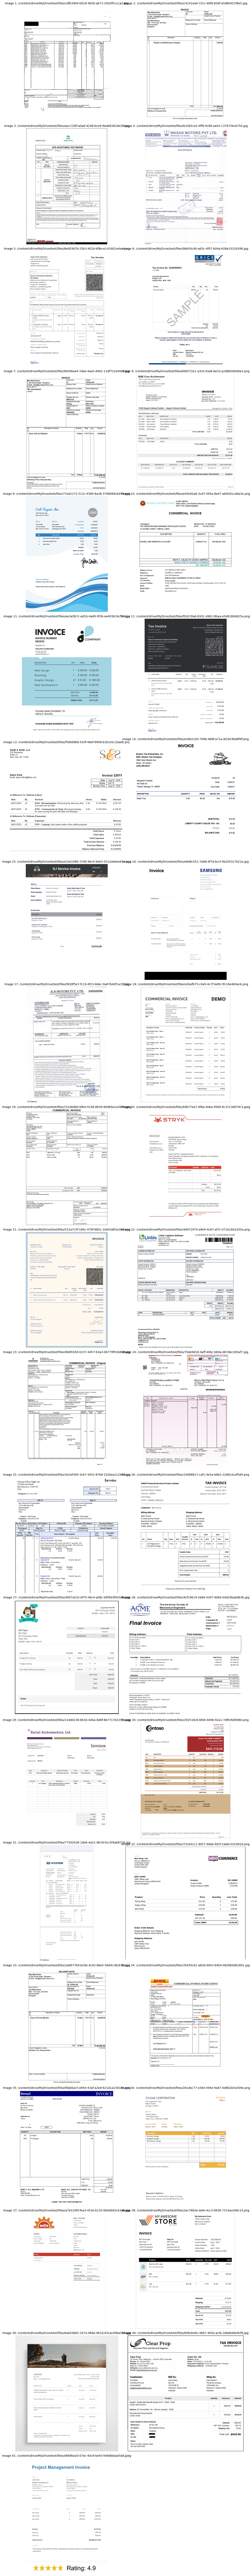

In [ ]:
num_rows = (len(image_paths) + 1) // 2
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 6 * num_rows))

for i, filepath in enumerate(image_paths):
    image = cv2.imread(filepath)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    row_idx = i // 2
    col_idx = i % 2
    ax = axes[row_idx, col_idx]
    ax.imshow(image_rgb)
    ax.axis('off')
    ax.set_title(f'Image {i+1}: {filepath}', fontsize=10, pad=5)

if len(image_paths) % 2 != 0:
    axes[num_rows - 1, 1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {api_key}"
}

prompt = '''I have provided an image file. From this image, please extract the following information.
         1) Invoice Number
         2) Issue Date of the Invoice
         3) Total Amount that has to be paid according to the Invoice
         4) The tabular data of the invoice which should be stored in form of string with each row in a single line with spaces in between column. Change line in the string after every row ends.

        Some text is writte in handwriting to extract that text as well as good as you can.
        Strictly follow the pattern which I have provided below.
        After getting all these information give the result in the given dictionary format.

        {"invoice_number":"<extractedInvoiceNumber>",
         "issue_date":"<extractedIssueDate>",
         "total":"<extractedTotalAmount>",
         "table":"header_00 header_01 header_02 ..... header_0n
                  item_00 item_01 item_02 ..... item_0n
                  item_10 item_11 item_12 ..... item_1n
                  ....
                  item_m0 item_m1 item_m2 ..... item_mn",
        }
        where, n = number of columns in the table
        and,   m = number of rows in the table

        If any data repeats in the table, then include all the repetitions.
        If any of the requested information is not present on the invoice, leave the respective value of the key blank and do not make things up.
        Include all the text of an item even if it is covering more than one row in the image. Change the row only if it is another item.
        Change Line of the string after every item (This is valid only for the "table" not in other parts of the dictionary)
        Do not exclude the headers of the table.
        Strictly follow the table pattern while generating the response.

        In the response, return me only the dictionary.'''

In [ ]:
def make_payload(image_path):
    base64_image = encode_image(image_path)
    payload = {
  "model": "gpt-4-vision-preview",
  "messages": [
      {"role": "system", "content": "You are a information extractor from handwritten images"},
    {
      "role": "user",
        "content": [
        {"type": "text", "text": prompt},
        {
          "type": "image_url",
          "image_url": {
            "url": f"data:image/jpeg;base64,{base64_image}",
          },
        },
      ]
    }
  ],
  "max_tokens": 300
}
    return payload

In [ ]:
def levenshtein_similarity(string1, string2):
  distance = Levenshtein.distance(string1, string2)
  similarity = 1 - (distance / max(len(string1), len(string2)))
  return similarity

In [ ]:
def find_bbox_coordinates(target_item, response):
  coordinates = None
  similarities = {}
  if(target_item == ""):
    return []
  for item in response:
    content = item[1][0]
    if content == target_item:
      coordinates = item[0]
      return coordinates

  for item in response:
    content = item[1][0]
    similarity = levenshtein_similarity(target_item, content)
    similarities[content] = similarity
  max_key = max(similarities, key=lambda k: similarities[k])
  for item in response:
    content = item[1][0]
    if content == max_key:
      coordinates = item[0]

  return coordinates

In [ ]:
def find_table_bbox(target_item, response):
  list1 = target_item.strip().split()
  list2=[]
  first = list1[0]
  last = list1[-1]
  coord_first = find_bbox_coordinates(first, response)
  coord_last = find_bbox_coordinates(last , response)
  coord1 = get_required_bbox(coord_first)
  coord2 = get_required_bbox(coord_last)
  return [coord1[0],coord1[1],coord2[2],coord2[3]]

In [ ]:
responses = []
bboxs = []

for filepath in image_paths:
    response_dict = {}
    image = cv2.imread(filepath)
    plt.imshow(image)
    plt.axis('off')
    payload = make_payload(filepath)
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    res = response.json()
    response_string = (res["choices"][0]["message"]["content"])
    responses.append(response_string)

plt.show()
print(len(responses))

In [ ]:
array_string = ' '.join(str(element) for element in responses)

In [ ]:
def post_process_response(string):
  processed_responses = []
  result = re.sub(r'}[^{}]+{', '},{', string)
  result = result.replace("json","")
  result = result.replace("```","")
  result_list = re.split(r',\s*{',result)
  result2 = ["{"+item for item in result_list[1:] ]
  result2.insert(0,result_list[0])
  for element in result2:
    element = element.replace('"',"'''")
    d = (eval(element))
    processed_responses.append(d)
  return processed_responses

In [ ]:
processed_responses = post_process_response(array_string)
print(processed_responses[0])

{'invoice_number': '21', 'issue_date': 'Dec 14 2016', 'total': '£775.00', 'table': 'Description of Goods Tariff Code Country of Origin Quantity Unit £ Total £\n              AL-D-6 Alison Tunic - Size: 6 100% Cotton 62044220 United Kingdom 1 £25.00 £25.00\n              AL-D-8 Alison Tunic - Size: 8 100% Cotton 62044220 United Kingdom 2 £25.00 £50.00\n              AL-D-10 Alison Tunic - Size: 10 100% Cotton 62044220 United Kingdom 2 £25.00 £50.00\n              AL-D-12 Alison Tunic - Size: 12 100% Cotton 62044220 United Kingdom 2 £25.00 £50.00\n              AL-D-14 Alison Tunic - Size: 14 100% Cotton 62044220 United Kingdom 4 £25.00 £100.00\n              AN-D-6 Angie Dress - Size: 6 100% Cotton 62044220 United Kingdom 2 £25.00 £'}


In [ ]:
def get_required_bbox(coordinates):
  if(coordinates == []):
    return []
  x_min = coordinates[0][0]
  y_min = coordinates[0][1]
  x_max = coordinates[2][0]
  y_max = coordinates[2][1]
  return [x_min,y_min,x_max,y_max]

In [ ]:
for i, filepath in enumerate(image_paths):
  result = ocr.ocr(filepath, cls=True)
  ino_coord = find_bbox_coordinates(processed_responses[i]["invoice_number"],result[0])
  date_coord = find_bbox_coordinates(processed_responses[i]["issue_date"],result[0])
  total_coord = find_bbox_coordinates(processed_responses[i]["total"], result[0])
  processed_responses[i]["invoice_number_bbox"] = get_required_bbox(ino_coord)
  processed_responses[i]["issue_date_bbox"] = get_required_bbox(date_coord)
  processed_responses[i]["total_bbox"] = get_required_bbox(total_coord)
  processed_responses[i]["table_bbox"] = find_table_bbox(processed_responses[i]["table"],result[0])

processed_responses

[2024/01/22 06:50:11] ppocr DEBUG: dt_boxes num : 83, elapsed : 0.07232451438903809
[2024/01/22 06:50:11] ppocr DEBUG: cls num  : 83, elapsed : 0.0835733413696289
[2024/01/22 06:50:11] ppocr DEBUG: rec_res num  : 83, elapsed : 0.32956647872924805
[2024/01/22 06:50:12] ppocr DEBUG: dt_boxes num : 115, elapsed : 0.07737946510314941
[2024/01/22 06:50:12] ppocr DEBUG: cls num  : 115, elapsed : 0.12029290199279785
[2024/01/22 06:50:12] ppocr DEBUG: rec_res num  : 115, elapsed : 0.3150794506072998
[2024/01/22 06:50:12] ppocr DEBUG: dt_boxes num : 39, elapsed : 0.04458785057067871
[2024/01/22 06:50:12] ppocr DEBUG: cls num  : 39, elapsed : 0.04307222366333008
[2024/01/22 06:50:12] ppocr DEBUG: rec_res num  : 39, elapsed : 0.14650464057922363
[2024/01/22 06:50:12] ppocr DEBUG: dt_boxes num : 162, elapsed : 0.10753774642944336
[2024/01/22 06:50:13] ppocr DEBUG: cls num  : 162, elapsed : 0.17067766189575195
[2024/01/22 06:50:13] ppocr DEBUG: rec_res num  : 162, elapsed : 0.49127197265625
[2024/0

{'invoice_number': '22011',
 'issue_date': 'Aug 01, 2020',
 'total': '$ 3,618.95',
 'table': 'Date By Services Hours Rates Amount\n               08/01/2020 JS A104 - Review/analyze: Reviewing the discovery that was sent over by Paul 2.30 $ 125.00/hr $ 287.50\n               08/01/2020 JS A105 - Communicate (in firm): Discussed strategy for case moving forward with Beth and Monique 0.84 $ 125.00/hr $ 105.00\n               Date By Expenses Amount\n               08/01/2020 JS E101 - Copying: Had copies made of the outline proposal $ 43.95',
 'invoice_number_bbox': [612.0, 188.0, 742.0, 208.0],
 'issue_date_bbox': [650.0, 222.0, 733.0, 239.0],
 'total_bbox': [670.0, 663.0, 736.0, 677.0],
 'table_bbox': [602.0, 223.0, 736.0, 608.0]}

In [ ]:
ino = []
ino_bb = []
idate = []
idate_bb = []
itotal = []
itotal_bb = []
itable = []
itable_bb = []
for item in processed_responses:
  ino.append(item["invoice_number"])
  ino_bb.append(item["invoice_number_bbox"])
  idate.append(item["issue_date"])
  idate_bb.append(item["issue_date_bbox"])
  itotal.append(item["total"])
  itotal_bb.append(item["total_bbox"])
  itable.append(item["table"])
  itable_bb.append(item["table_bbox"])



In [ ]:
df = pd.DataFrame({"title":image_paths, "invoice_number": ino, "invoice_number_bbox":ino_bb , "issue_date":idate, "issue_date_bbox":idate_bb, "total":itotal, "total_bbox":itotal_bb,"table":itable,"table_bbox":itable_bb})
df

title       invoice_number  \
0    fd28f5e7-fc19-4f23-8dec-9a87b40f1a15.jpg      KBM/15-16/S0229   
1    c4141ea0-72cc-46f8-826f-a5d80451f8e5.jpg                   38   
2    77502028-18e6-4a51-9b7d-0cc5f4a68726.jpg      S1405G202003284   
3    e8d8c551-7a88-4f7d-bccf-4b205317b21e.jpg         123456789-SA   
4    a7e533f9-fea3-453e-b135-6b6d9d3c63a6.jpg                   48   
5    4907a532-bf75-4bc4-a08c-06f9d3f00306.png                    1   
6    19d98817-caf1-4e5a-b8b2-22881ecef5d4.png              2017-40   
7    2ec7883e-dafe-4cc3-9836-7314ace98c14.png          2022/000323   
8    292518c6-bfd4-4096-92a1-7df63faf0860.png  CIV-000676 000007-1   
9    aacc330f-a0ad-4248-bce9-9eab83818e2b.jpg                        
10   77ed1272-512c-4389-8a38-3798084cb073.png               US-001   
11   9b650c90-ad5c-4f07-b04a-b58e33318398.jpg           GS00000001   
12   6a620b62-167a-466e-961d-63cac09ba563.jpg                  001   
13   522a7c5f-166c-479f-8801-10d43d83a3b9.png           CT00000001   
14   8e00367b-25b3-401b-bf8e-e1cfc801e4ae.png      GE/3847/20-2013   
15   f0cb78a6-b501-4962-8baa-e5d8180d625a.png      GE/3847/20-2013   
16   b06572e1-a3c6-43a8-8e33-a2d8b5669da3.png                 1227   
17   70de9d18-4aff-40bc-b60a-db7dec2b5af7.jpg                33984   
18   e32e1986-37d9-46c9-9e63-551a3e6ee83a.png                    1   
19   2a8677b9-b29e-4c93-86e5-56d4c38cb7fc.jpg                    1   
20   ee3a5b7c-ed1b-4a89-9f36-ee403616cf5d.jpg               982093   
21   e45e92a6-3cd7-495a-8e47-ab95d1cdda3e.png          CI-10012014   
22   9d396ae4-7abe-4aa5-8481-11df722e49c7.jpg                   37   
23   b33b5ce3-4ff8-4c88-aa43-137875bcb754.jpg   JC-Was@-011-011504   
24  0869be20-07ec-40c9-be93-fe9d6b0ae5dd.jpeg                        
25   21dd0238-661b-4d4a-8d6f-8b7717d229fc.png            0219-0001   
26   0b6fcb50-b157-4457-b3a3-06779f91b8b8.jpg              4631508   
27   f50b68b8-543f-48ef-999d-b1b142c1baeb.png                22011   
28   4cfc9619-5dd4-4307-90b6-04d20ba6db3b.jpg             CRM12345   
29   e34b2104-7996-488f-a71a-af1819bd8f9f.png                   25   
30   e2befb75-c0e9-4c7f-befd-3fc16e4b9acb.png                   21   
31   281dec77-e364-494e-9a67-0d862b5a509e.png               #00121   
32   6fab0ac5-e856-43af-a2ed-621d1a15818a.png                    1   
33   151d0d84-bfb4-4338-8839-90d69a1a3074.png  INCO-3764-CIRA-5789   
34   7b450c61-a83d-4843-8404-0828b0d62891.jpg        1234 567 8912   
35   4d972974-e804-4c67-af7c-071b16d1d35a.png             PD004918   
36   cdfb3904-b918-4b56-ab73-20d3ffcccca5.jpg           S016033686   
37  69b77ea7-6f8a-4eba-9568-8c33136879c3.jpeg                 0001   
38   608cb44c-46b7-405e-acfa-1bb8ed4e9cf8.jpg                  100   
39   72c641c1-d057-48ab-9d1f-2abb143c691d.png             BS 10009   
40   3e2ef304-3cb7-4452-87b8-102bea1c2908.jpg                30037   

                 invoice_number_bbox             issue_date  \
0     [1130.0, 309.0, 1394.0, 337.0]             31/08/2015   
1         [249.0, 46.0, 265.0, 58.0]              19-Nov-20   
2       [123.0, 779.0, 369.0, 804.0]  2020-03-07 17:49:27.0   
3     [509.0, 1696.0, 745.0, 1736.0]           14 Sept 2017   
4       [520.0, 560.0, 563.0, 595.0]             18/12/2014   
5       [521.0, 241.0, 531.0, 252.0]               7/9/2015   
6         [651.0, 79.0, 841.0, 97.0]             20-07-2017   
7       [384.0, 169.0, 555.0, 182.0]           July 7, 2022   
8       [515.0, 138.0, 729.0, 152.0]       30 November 2019   
9                                 []                          
10      [612.0, 227.0, 657.0, 242.0]             11/02/2019   
11      [338.0, 280.0, 376.0, 291.0]              1/01/2008   
12      [206.0, 459.0, 271.0, 474.0]        15 October 2018   
13      [389.0, 553.0, 453.0, 568.0]       October 10, 2020   
14      [627.0, 110.0, 688.0, 128.0]             10/10/2020   
15       [30.0, 112.0, 191.0, 126.0]       October 10, 2020   
16    [463.0, 1243.0, 514.0,

In [ ]:
df.to_csv('prediction.csv', index=False)
